In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm


In [2]:
# Prob (a): Dataset creation
def create_dataset(n: int, seed: int = None) -> Tuple[torch.Tensor, torch.Tensor]:
    if seed is not None:
        np.random.seed(seed)
    x = np.random.uniform(0, 1, n)
    y = np.sin(10 * np.pi * x ** 4)
    return torch.FloatTensor(x.reshape(-1, 1)), torch.FloatTensor(y.reshape(-1, 1))

# True function
def f_star(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(10 * np.pi * x ** 4)


In [3]:
# Prob(b): MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_model(X: torch.Tensor, y: torch.Tensor, epochs: int = 2000) -> MLP:
    model = MLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    return model

# Evaluation functions
def compute_delta(model: MLP, x_range: Tuple[float, float], n_points: int = 1000) -> float:
    model.eval()
    x_test = torch.linspace(x_range[0], x_range[1], n_points).reshape(-1, 1)
    with torch.no_grad():
        y_pred = model(x_test)
        y_true = f_star(x_test)
        delta = torch.max(torch.abs(y_pred - y_true)).item()
    return delta

def compute_deltas(model: MLP) -> Tuple[float, float]:
    delta_in = compute_delta(model, (0, 1))
    delta_out = compute_delta(model, (0, 1.5))
    return delta_in, delta_out

def run_experiment(n: int, seed: int = None) -> Tuple[float, float]:
    X, y = create_dataset(n, seed)
    model = train_model(X, y)
    return compute_deltas(model)


In [4]:
# Prob (c): Run experiments
ns = np.logspace(1, 3, 20).astype(int)
results = {n: {'delta_in': [], 'delta_out': []} for n in ns}

for n in tqdm(ns):
    # Create 5 training datasets for each n
    for seed in range(5):
        delta_in, delta_out = run_experiment(n, seed)
        results[n]['delta_in'].append(delta_in)
        results[n]['delta_out'].append(delta_out)


100%|██████████| 20/20 [04:27<00:00, 13.36s/it]


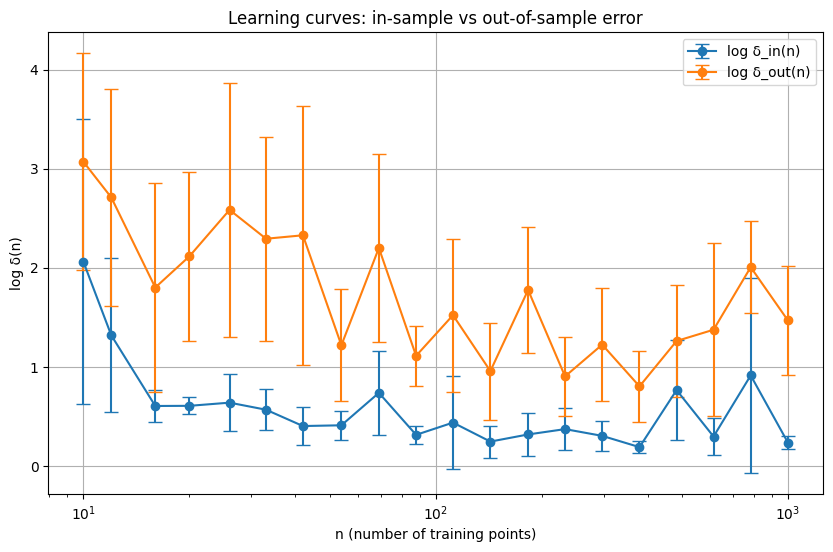

In [5]:
# Compute statistics
delta_in_mean = [np.mean(results[n]['delta_in']) for n in ns]
delta_in_std = [np.std(results[n]['delta_in']) for n in ns]
delta_out_mean = [np.mean(results[n]['delta_out']) for n in ns]
delta_out_std = [np.std(results[n]['delta_out']) for n in ns]

# Create plot
plt.figure(figsize=(10, 6))
plt.errorbar(ns, np.log(delta_in_mean), yerr=np.array(delta_in_std) / np.array(delta_in_mean),
             label='log δ_in(n)', fmt='o-', capsize=5)
plt.errorbar(ns, np.log(delta_out_mean), yerr=np.array(delta_out_std) / np.array(delta_out_mean),
             label='log δ_out(n)', fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('n (number of training points)')
plt.ylabel('log δ(n)')
plt.legend()
plt.grid(True)
plt.title('Learning curves: in-sample vs out-of-sample error')
plt.show()


C:\Users\Bw Jiang\AppData\Local\Temp\ipykernel_18524\2194218618.py:12: RuntimeWarning: invalid value encountered in log
  np.log(delta_in_means - delta_in_stds),
C:\Users\Bw Jiang\AppData\Local\Temp\ipykernel_18524\2194218618.py:19: RuntimeWarning: invalid value encountered in log
  np.log(delta_out_means - delta_out_stds),


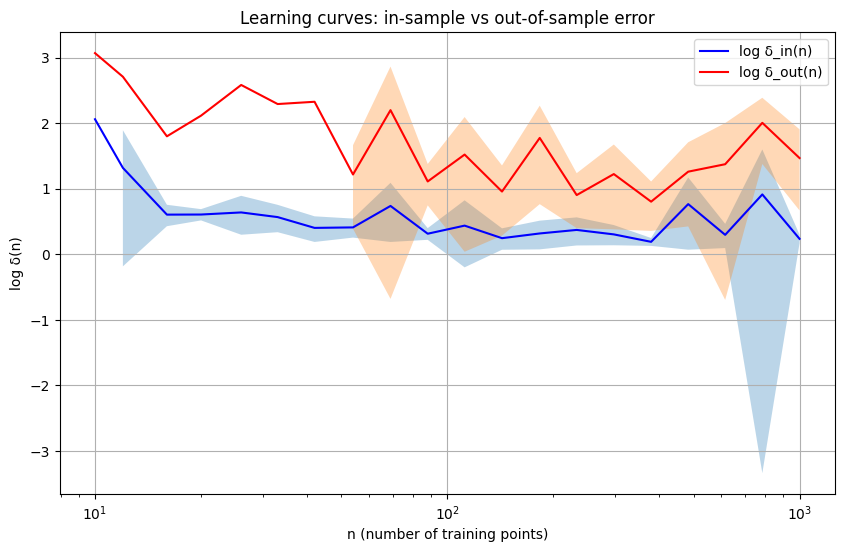

In [6]:
# Compute mean and standard deviation for both δfin(n) and δfout(n)
delta_in_means = np.array([np.mean(results[n]['delta_in']) for n in ns])
delta_in_stds = np.array([np.std(results[n]['delta_in']) for n in ns])
delta_out_means = np.array([np.mean(results[n]['delta_out']) for n in ns])
delta_out_stds = np.array([np.std(results[n]['delta_out']) for n in ns])

# Create plot
plt.figure(figsize=(10, 6))

# Plot log δfin(n) with error bars
plt.fill_between(ns, 
                 np.log(delta_in_means - delta_in_stds),
                 np.log(delta_in_means + delta_in_stds),
                 alpha=0.3)
plt.plot(ns, np.log(delta_in_means), 'b-', label='log δ_in(n)')

# Plot log δfout(n) with error bars
plt.fill_between(ns, 
                 np.log(delta_out_means - delta_out_stds),
                 np.log(delta_out_means + delta_out_stds),
                 alpha=0.3)
plt.plot(ns, np.log(delta_out_means), 'r-', label='log δ_out(n)')

plt.xscale('log')
plt.xlabel('n (number of training points)')
plt.ylabel('log δ(n)')
plt.legend()
plt.grid(True)
plt.title('Learning curves: in-sample vs out-of-sample error')
plt.show()